# Fine-tunining Meta OPT-125M with "War and Peace"

The goal of this notebook is to fine-tune a language model to generate texts that closely match Tolstoy's style in his iconic "War and Peace" writing.

1. Fetch model and tokenizer from the huggingface repository
2. Download the book and preprocess it by breaking content into paragraphs and skipping non-significant parts like table of contents and copyright info.
3. Fine-tune the model on a few thousand steps.
4. Validate the fine-tuned model with a few metrics.
5. Evaluate the results with a few prepared sample prompts.


### Dependecies

1. Install `datasets` and upgrade `accelerate` libraries

In [ ]:
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Fetching Model and Tokenizer from Huggingface

In [ ]:
from transformers import AutoTokenizer

model_name = "facebook/opt-125m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
model.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

## Dataset Preprocessing

In [ ]:
!curl -O https://www.gutenberg.org/cache/epub/2600/pg2600.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3280k  100 3280k    0     0  3324k      0 --:--:-- --:--:-- --:--:-- 3324k


In [ ]:
start_text = False

merge_lines  = []

with open('paragraphs.txt', 'w') as output:
    with open('pg2600.txt', 'r') as f:
        for t in f:
            if t == "BOOK ONE: 1805\n":
                start_text = True
                continue
            if start_text:
                if t == "*** END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE ***\n":
                    break
                if str.isupper(t):
                    continue
                if len(t) > 1:
                    merge_lines.append(t.strip())
                else:
                    if len(merge_lines) > 0:
                        output.write(" ".join(merge_lines) + "\n")
                        output.flush()
                    merge_lines = []

In [ ]:
with open('paragraphs.txt', 'r') as f:
    texts = f.readlines()
    outputs = tokenizer(texts, return_attention_mask=False)

Each paragraph is tokenized, and min length of input sequence is 5 and max os 939. Can easily fit into the model width input!

In [ ]:
min([len(x) for x in outputs.input_ids]), max([len(x) for x in outputs.input_ids]), 1024

(5, 939, 1024)

In [ ]:
from datasets import Dataset

def gen():
    with open("paragraphs.txt") as f:
        for line in f:
            yield {"text": line.strip()}

dataset = Dataset.from_generator(gen)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def preprocess(example):
    return tokenizer(example['text'],
        padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=['text']).with_format("torch")

Map:   0%|          | 0/11330 [00:00<?, ? examples/s]

## Fine-tuning

In [ ]:
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


training_args = TrainingArguments(
    output_dir="output_model",
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.05,
    per_device_train_batch_size=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator
)

trainer.train()

Step,Training Loss
500,3.350000
1000,3.191400
1500,3.170100
2000,3.110600
2500,3.091900


TrainOutput(global_step=2833, training_loss=3.169040603179878, metrics={'train_runtime': 1412.2244, 'train_samples_per_second': 8.023, 'train_steps_per_second': 2.006, 'total_flos': 4727308711680000.0, 'train_loss': 3.169040603179878, 'epoch': 1.0})

In [ ]:
output_model_dir = "./trained_model"

model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

## Generation Function

I played a bit with generation parameters and prefered to go with ones below. The model tends to generate non-complete responses and repeat itself a lot under the default generation settings.

In [ ]:
import textwrap

def generate(prompt):
  inputs = tokenizer(prompt, return_tensors="pt")
  inputs = {key: value.to("cuda") for key, value in inputs.items()}

  input_seq_length = len(inputs)
  outputs = model.generate(**inputs,
                           do_sample=True,
                           temperature=0.3,
                           top_p=0.5,
                           max_length=256,
                           exponential_decay_length_penalty=[64, 1.01],
                           repetition_penalty=1.3)[0]
  return tokenizer.decode(outputs)


def format_input_output(prompt):
  output = generate(prompt)

  print(f"Prompt:\n{textwrap.fill(prompt, 80)}\n")
  print(f"Response:\n{textwrap.fill(output[(len(prompt) + 4):-4].strip(), 80)}")

# Validation

Let's validate the fine-tuning results via calculating preplexity for the same samples from Wikipedia dataset. We draw distributions for both original and fine-tuned model, and see if there is a horrific difference or not.

If difference in distributions is neglectable, we can safely say the model was fine-tuned fine. If not, we failed!

I'm aware that this validation example is simply for the demonstration purpose. We could've run a larger extensive set of tests but it's done the way it's done for the sake of simplicity.

In [ ]:
import evaluate
import datasets


def compute_preplexity(model_name):
  perplexity = evaluate.load("perplexity", module_type="metric")
  input_texts = datasets.load_dataset("wikitext",
                                      "wikitext-2-raw-v1",
                                      split="test")["text"][:500]
  input_texts = [s for s in input_texts if s!='']
  results = perplexity.compute(model_id=model_name,
                              predictions=input_texts)
  return results

In [ ]:
original_ppl = compute_preplexity(model_name).get('perplexities')
trained_ppl = compute_preplexity(output_model_dir).get('perplexities')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
import numpy as np

print(f"Ori:\t{np.mean(original_ppl):.2f} +/- {np.std(original_ppl):.2f}")
print(f"FT:\t{np.mean(trained_ppl):.2f} +/- {np.std(trained_ppl):.2f}")

Ori:	322.41 +/- 1115.55
FT:	918.15 +/- 4110.26


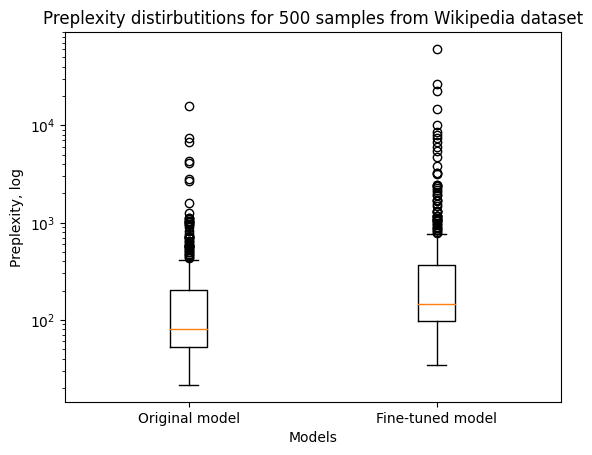

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([original_ppl, trained_ppl],
                     vert=True,  # vertical box alignment
            labels=['Original model', 'Fine-tuned model']
  );
plt.xlabel('Models')
plt.ylabel('Preplexity, log')
plt.yscale('log');  # fill with color)  # will be used to label x-ticks
plt.title('Preplexity distirbutitions for 500 samples from Wikipedia dataset');

Preplexity skyrocketed when the model was fine-tuned which can be expected during fine-tuning. The preplexity distribution shapes resembles each other on larger scale. The fine-tuned model might exhibit degradative behavior when it comes to general use cases.  

## Sample Prompts

The model seems to learn to mimic the style of the Tolstoy's writing yet it seems to halucinate a bit.

In [ ]:
format_input_output("Can you describe what Natasha Rostova looks like?")

Prompt:
Can you describe what Natasha Rostova looks like?

Response:
” asked Natásha. “She is a very beautiful girl, but she has not yet grown up and
her face is quite different from that of the old princess. She seems to me so
much more feminine than before—a little more feminine, with a smile on her lips
and a slight frown in her eyes. I have seen her at dinner, when she was still
young, and now she is as good-looking as ever! And how does one know this?” said
Natásha. “I am sure it will be difficult for anyone to understand it all. But I
think there are many people who would love her. They say she is a pretty woman,
and they say she is a handsome lady too. So why should we judge her by her
beauty? It is impossible to judge her by her appearance alone.”


In [ ]:
format_input_output("What battles did Pierre Bezukhov win?")

Prompt:
What battles did Pierre Bezukhov win?

Response:
What victories were he able to make in the army of Napoleon and his troops, or
what was his strength at all? How could he have won a battle without losing it?
And how had he not lost one of those battles which seemed so important for
him—the Battle of Borodinó? The French army, as well as the Russians, were
unable to advance on Moscow. But that is why they are now fighting against each
other: because they know that if they attack the enemy’s front line they will be
forced into action. If they do not attack the enemy’s front line, then their
whole force will perish; but if they attack the enemy’s front line, then their
whole force will die. That is why they should fight with such intensity and
determination!


In [ ]:
format_input_output("What kind of fishes swim in the Pacific ocean?")

Prompt:
What kind of fishes swim in the Pacific ocean?

Response:
What is it that makes them so strong and how do they get there? How does one
make a man’s life, or even his own, as he pleases? And what are these fish
called? They all have their own peculiarities. The first is the fact that they
can be quite different from other animals; but the second is the fact that they
cannot be compared to any other animal—the sea-life which has been described by
the French as “a great, majestic creature.” But this is not the same thing as
the fact that they may be very similar to us. In our day we had only two kinds
of fish: those who were small and agile, and those with large, muscular bodies.
We now know that the latter type was the most powerful, and that the former was
the least powerful.
